In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.datasets import mnist
import numpy as np

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.datasets import mnist
import numpy as np



In [20]:
# Cập nhật optimizer để thêm Gradient Clipping
optimizer = optimizers.Adam(clipvalue=1.0)  # clipvalue giới hạn giá trị gradient ở mức 1.0


In [21]:
# Build the model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_simple_nn():
  model = Sequential([
      Flatten(input_shape=(28, 28, 1)),
      Dense(128, activation='relu'),
      Dense(10, activation='softmax')
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [22]:
def create_cnn():
  model = Sequential([
      layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
      layers.MaxPooling2D(pool_size=2),
      layers.Conv2D(64, kernel_size=3, activation='relu'),
      layers.MaxPooling2D(pool_size=2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [23]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add channel dimension
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

In [24]:
victim_epochs = 10
victim_batch_size = 128

In [25]:
# Hàm Gradient Masking
def apply_gradient_masking(grads, mask_prob=0.2):
    """
    Hàm thực hiện Gradient Masking.
    grads: Danh sách gradients từ quá trình backpropagation.
    mask_prob: Tỷ lệ gradient bị che giấu (giá trị bị đặt thành 0 hoặc NaN).
    """
    masked_grads = []
    for grad in grads:
        if grad is not None:  # Kiểm tra gradient hợp lệ
            # Tạo mask ngẫu nhiên với xác suất mask_prob
            mask = tf.cast(tf.random.uniform(grad.shape) > mask_prob, grad.dtype)
            masked_grad = grad * mask  # Áp dụng mask
            masked_grads.append(masked_grad)
        else:
            masked_grads.append(None)
    return masked_grads

In [26]:
# Custom Training Loop with Gradient Masking and History Tracking
def train_with_gradient_masking(model, x_train, y_train, epochs, batch_size, mask_prob):
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    
    # Lưu lịch sử
    history = {
        "loss": [],
        "accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_loss = 0
        correct_preds = 0
        total_samples = 0
        
        for step, (x_batch, y_batch) in enumerate(dataset):
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = loss_fn(y_batch, predictions)
            
            # Tính gradients
            grads = tape.gradient(loss, model.trainable_variables)
            
            # Áp dụng Gradient Masking
            masked_grads = apply_gradient_masking(grads, mask_prob)
            
            # Cập nhật trọng số mô hình
            optimizer.apply_gradients(zip(masked_grads, model.trainable_variables))
            
            # Tích lũy mất mát
            epoch_loss += loss.numpy() * x_batch.shape[0]
            correct_preds += np.sum(np.argmax(predictions.numpy(), axis=1) == y_batch.numpy())
            total_samples += x_batch.shape[0]
        
        # Tính toán loss và accuracy trung bình cho epoch
        epoch_loss /= total_samples
        epoch_accuracy = correct_preds / total_samples
        
        # Validation
        val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
        
        # Lưu vào history
        history["loss"].append(epoch_loss)
        history["accuracy"].append(epoch_accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)
        
        print(f"Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")
    
    return history


## Simple_CNN

In [27]:
# Create Simple CNN model
simple_nn_model = create_simple_nn()

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
history_simple_nn_model = train_with_gradient_masking(
    model=simple_nn_model,
    x_train=x_train,
    y_train=y_train,
    epochs=10,
    batch_size=128,
    mask_prob=0.2  # Tỷ lệ Gradient Masking
)


Epoch 1/10
Loss: 0.3909 - Accuracy: 0.8919 - Val Loss: 0.2219 - Val Accuracy: 0.9372
Epoch 2/10
Loss: 0.1920 - Accuracy: 0.9455 - Val Loss: 0.1615 - Val Accuracy: 0.9534
Epoch 3/10
Loss: 0.1404 - Accuracy: 0.9602 - Val Loss: 0.1310 - Val Accuracy: 0.9621
Epoch 4/10
Loss: 0.1096 - Accuracy: 0.9688 - Val Loss: 0.1139 - Val Accuracy: 0.9657
Epoch 5/10
Loss: 0.0886 - Accuracy: 0.9749 - Val Loss: 0.1034 - Val Accuracy: 0.9692
Epoch 6/10
Loss: 0.0737 - Accuracy: 0.9792 - Val Loss: 0.0978 - Val Accuracy: 0.9710
Epoch 7/10
Loss: 0.0622 - Accuracy: 0.9828 - Val Loss: 0.0941 - Val Accuracy: 0.9719
Epoch 8/10
Loss: 0.0532 - Accuracy: 0.9855 - Val Loss: 0.0924 - Val Accuracy: 0.9731
Epoch 9/10
Loss: 0.0458 - Accuracy: 0.9877 - Val Loss: 0.0909 - Val Accuracy: 0.9737
Epoch 10/10
Loss: 0.0398 - Accuracy: 0.9892 - Val Loss: 0.0910 - Val Accuracy: 0.9733


In [29]:
simple_nn_model.save("./Gradient_Masking/victim_simple_cnn_model.keras")

In [30]:
loss, acc = simple_nn_model.evaluate(x_test, y_test)
print(f"Victim Model Accuracy On Test Set: {acc * 100.0:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9690 - loss: 0.1080
Victim Model Accuracy On Test Set: 97.33%


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


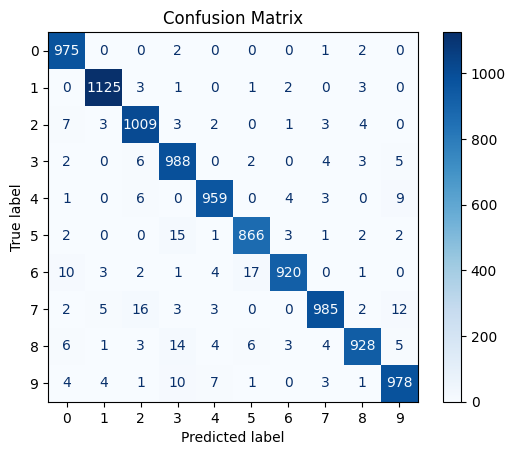

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class probabilities
y_pred_prob = simple_nn_model.predict(x_test)

# Convert predictions to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

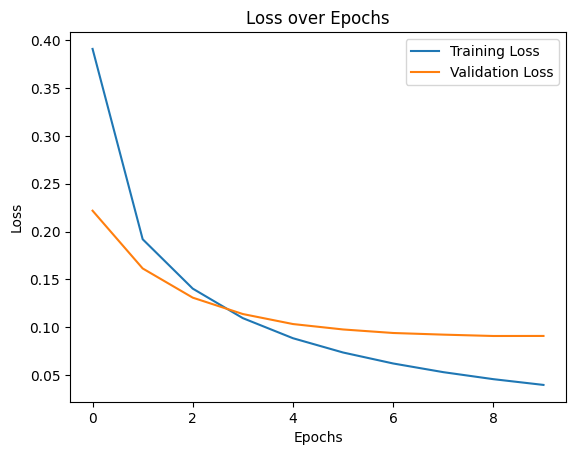

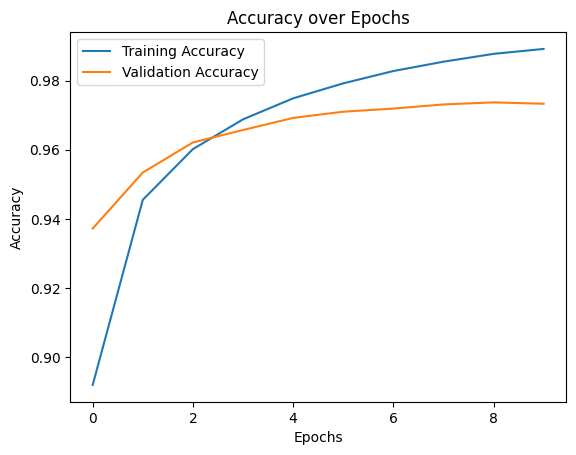

In [32]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history_simple_nn_model['loss'], label='Training Loss')
plt.plot(history_simple_nn_model['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_simple_nn_model['accuracy'], label='Training Accuracy')
plt.plot(history_simple_nn_model['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Convolutional CNN

In [33]:
# Define victim model
c_nn_model = create_cnn()

c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
# Train victim model
history_c_nn_model = train_with_gradient_masking(
    model=c_nn_model,
    x_train=x_train,
    y_train=y_train,
    epochs=10,
    batch_size=128,
    mask_prob=0.2  # Tỷ lệ Gradient Masking
)

Epoch 1/10
Loss: 0.2476 - Accuracy: 0.9293 - Val Loss: 0.0842 - Val Accuracy: 0.9727
Epoch 2/10
Loss: 0.0669 - Accuracy: 0.9795 - Val Loss: 0.0544 - Val Accuracy: 0.9814
Epoch 3/10
Loss: 0.0457 - Accuracy: 0.9863 - Val Loss: 0.0440 - Val Accuracy: 0.9844
Epoch 4/10
Loss: 0.0341 - Accuracy: 0.9899 - Val Loss: 0.0408 - Val Accuracy: 0.9854
Epoch 5/10
Loss: 0.0265 - Accuracy: 0.9922 - Val Loss: 0.0365 - Val Accuracy: 0.9885
Epoch 6/10
Loss: 0.0211 - Accuracy: 0.9937 - Val Loss: 0.0444 - Val Accuracy: 0.9860
Epoch 7/10
Loss: 0.0176 - Accuracy: 0.9947 - Val Loss: 0.0394 - Val Accuracy: 0.9884
Epoch 8/10
Loss: 0.0137 - Accuracy: 0.9956 - Val Loss: 0.0361 - Val Accuracy: 0.9889
Epoch 9/10
Loss: 0.0118 - Accuracy: 0.9962 - Val Loss: 0.0423 - Val Accuracy: 0.9887
Epoch 10/10
Loss: 0.0091 - Accuracy: 0.9973 - Val Loss: 0.0369 - Val Accuracy: 0.9894


In [35]:
c_nn_model.save("./Gradient_Masking/victim_cnn_model.keras")

In [36]:
# Evaluate victim model
loss, acc = c_nn_model.evaluate(x_test, y_test)
print(f"Victim Model Accuracy On Test Set: {acc * 100.0:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9861 - loss: 0.0471
Victim Model Accuracy On Test Set: 98.94%


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


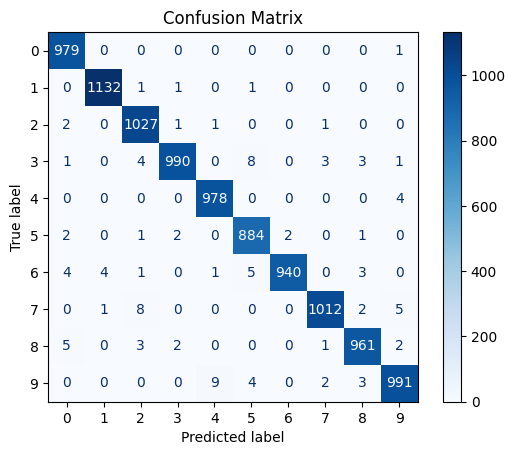

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class probabilities
y_pred_prob = c_nn_model.predict(x_test)

# Convert predictions to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

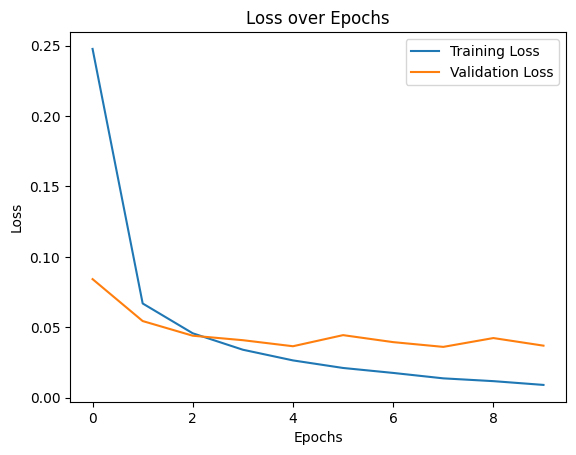

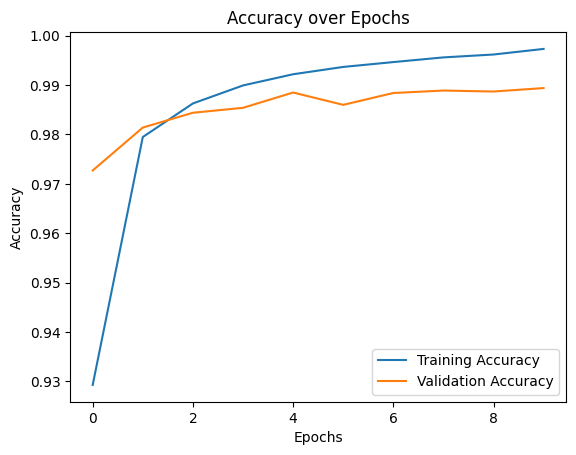

In [38]:
# Accessing and Displaying Training History
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history_c_nn_model['loss'], label='Training Loss')
plt.plot(history_c_nn_model['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_c_nn_model['accuracy'], label='Training Accuracy')
plt.plot(history_c_nn_model['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()